# *Bicycles by the Numbers*: A Tale of Two Wheels       ![title](img/cyclist.png)                         

### For a variety of reasons, I'm interested in the number of cyclists on our roads.  I've had good and bad interactions with others involving bicycles: as a cyclist myself, as a motorist, and as a pedestrian.

### The idea of taxing or licensing comes up periodically, and is consistently shot down.  Still, it may come to pass.  While less than a typical passenger vehicle, bicycles do have an impact on infrastructure, traffic patterns, pollution, health... the list goes on.

### Whether for taxation/licensure, installing new bicycle lanes, predicting commuter traffic, or any number of other reasons, having some idea of the accurate numbers and locations of bicycles through time is essential to making good decisions.

### Unfortunately, I couldn't find data to download for Portland.  There are several automatic counters installed, but no apparent way to access the raw data.  Seattle, on the other hand, has data that's easily accessible.  Proportional to population, it's a good bet that Portland and Seattle are very similar.

### Weather is likely the largest influence in the choice to ride or not.  Now that the Federal government is funded, I was again able to access weather data from NOAA; for this project it's the SeaTac station.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
import xgboost as xgb

In [2]:
pd.set_option('display.max_columns', 500)     # get rid of display truncation for columns
pd.set_option('display.max_rows', 500)        # and rows

In [3]:
counts = pd.read_csv('bike_counts.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('bike_weather.csv', index_col='DATE', parse_dates=True)

## Resample frequency from hourly to daily

In [4]:
# sampling is hourly in the dataset; Instead, convert
# and sum to create one row per day, rather than 24 rows
daily = counts.resample('d').sum()
daily['Total'] = (daily.sum(axis=1)).astype(np.uint16)
daily = daily[['Total']]

### The Fremont Bridge in Seattle is where this data was gathered; there are automatic sensors that log passing bicycles on either side of the bridge (East and West).  The bridge is one of the crossing points of Lake Union, which divides the city into (roughly) a downtown area and a northern area.  As such, it's an excellent point to get a good sense of traffic flow to and from downtown.

In [5]:
counts.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2018-12-31 23:00:00,7.0,6.0
2018-12-31 22:00:00,3.0,4.0
2018-12-31 21:00:00,7.0,7.0
2018-12-31 20:00:00,12.0,14.0
2018-12-31 19:00:00,9.0,5.0


In [6]:
# simplify the column names, create a Total column
counts.columns = ['East', 'West']
counts['Total'] = counts['East'] + counts['West']

### Big picture statistics (hourly, not daily)

In [7]:
# also do with: "with pd.option_context('display.float_format', '{:.0f}'.format):"
# both cases require use of print, plain describe() is just blank
with pd.option_context('display.precision', 0):
    print(counts.describe())

        East   West  Total
count  54735  54735  54735
mean      53     58    111
std       68     85    140
min        0      0      0
25%        7      7     15
50%       29     29     60
75%       70     70    144
max      698    717    957


# Bicycle traffic on Seattle's Fremont Bridge, East and West
### Very interesting: look at the change in east/west traffic in 2017 and 2018.  Where previously they nearly mirrored each other, suddenly Westbound is significantly higher.  I wonder if there is a new route that's opened, making a Westbound ride on the bridge preferable?  Perhaps a circuit that wasn't previously available?

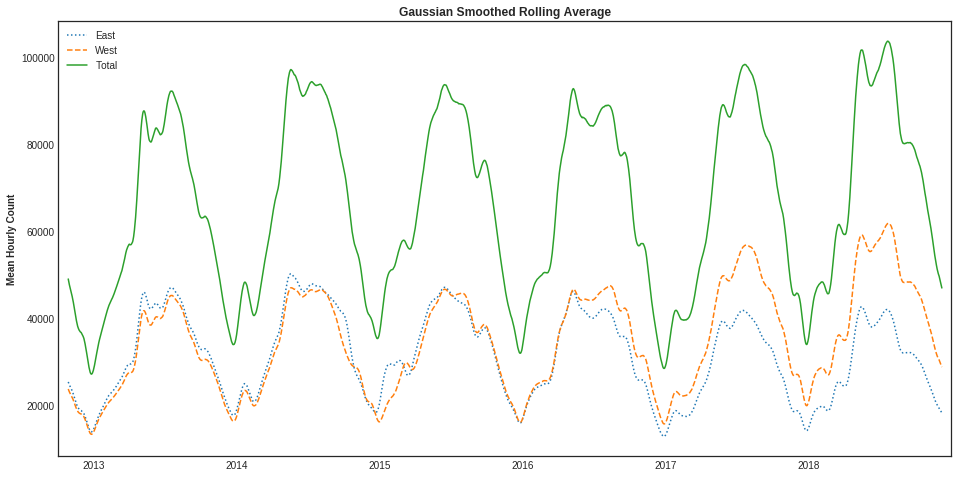

In [8]:
plt.style.use('seaborn-white')
daily_avg = counts.resample('D').sum()
daily_avg.rolling(50, center=True,
                  win_type='gaussian').sum(std=10).plot(style=[':', '--', '-'], figsize=(16,8))
plt.ylabel('Mean Hourly Count', fontweight='bold')
plt.xlabel('')
plt.title('Gaussian Smoothed Rolling Average', fontweight='bold');

### As we might expect, there's a strongly bimodal pattern, reflecting morning and evening commute patterns.  Weekends show a leisure/activity style with a broader single peak.  Folks are getting out for long rides on the weekend!

### Curiously ,the numbers for the morning and evening commute don't match: more people are riding back from work than to work.

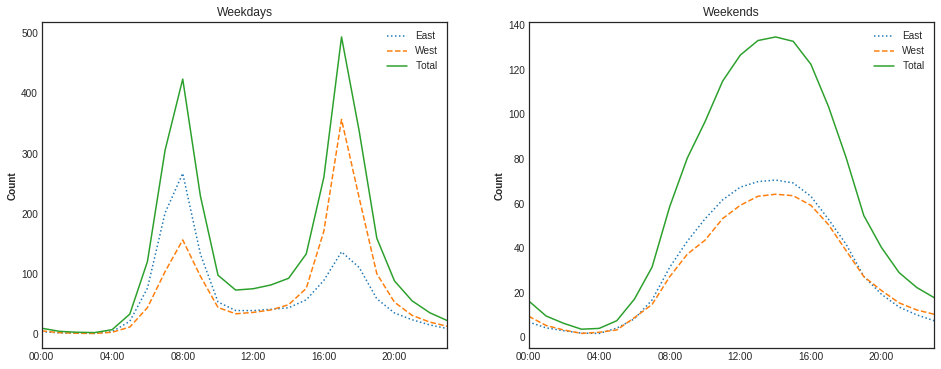

In [9]:
plt.style.use('seaborn-white')
hourly_ticks = 4 * 60 * 60 * np.arange(6)
weekend = np.where(counts.index.weekday < 5, 'Weekday', 'Weekend')
groupby_time = counts.groupby([weekend, counts.index.time]).mean()
fig, ax = plt.subplots(1, 2, figsize=(16,6))
groupby_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                                xticks=hourly_ticks, style=[':', '--', '-'])
groupby_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                                xticks=hourly_ticks, style=[':', '--', '-'])
for axis in ax:
    axis.set_xlabel('')
    axis.set_ylabel('Count', fontweight='bold')
plt.show()

# _Feature Engineering_

### Join in weather data and US Holidays.
There are a number of weather stations in Seattle that are closer than SeaTac; however, they are not nearly as complete when compared to Seatac.  Many of them had around 60% coverage, and reported far fewer types of data.

In [10]:
# functions to ease feature creation
def make_feature(condition: 'boolean expr') -> 'boolean mask':     # function annotations
    '''Create new feature as 0 or 1, uses np.where()'''
    return np.where(condition, 1, 0).astype(np.uint8)


# Algorithm/calculation is 'standard' in astronomy circles, found online
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    '''Compute hours of daylight for a given date and latitude'''
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1.0 - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24.0 * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.0

### Most of the features are created from the weather data.  There are obbvious things like min/max temperatures, rain, and snow.  More interesting are combinations, such as being both warm *and* sunny, or cold *and* rainy.

### It appears that there's a big uptick every year around May, and I'm thinking about a feature that tracks a sudden bout of clear weather following a steady period of rain.

In [11]:
# start getting creative with the weather
weather['avg_temp_F'] = 0.5 * (weather['TMIN'] + weather['TMAX'])
weather['dry_day'] = (weather['PRCP'] == 0)
weather['PRCP'] = weather['PRCP'].round(2)
weather['snow'] = make_feature(weather['SNOW'] > 0)

cols = ['TMIN', 'TMAX', 'avg_temp_F', 'PRCP', 'dry_day', 'snow']
daily = daily.join(weather[cols])
daily.rename(columns={'TMIN':'min_temp_F', 'TMAX':'max_temp_F'}, inplace=True)

# breaking out make_feature() decreased visual noise in the code slightly
daily['hvy_prcp'] = make_feature(daily['PRCP'] >= 0.5)
daily['cold_rain'] = make_feature((daily['PRCP'] >= 0.2) & (daily['max_temp_F'] <= 40))
daily['warm'] = make_feature(daily['max_temp_F'] >= 60)
daily['warm_sunny'] = make_feature((daily['warm']) & (daily['PRCP'] == 0))
daily['hot'] = make_feature(daily['max_temp_F'] >= 85)
daily['cold'] = make_feature(daily['max_temp_F'] <= 45)

days = 'Mon Tue Wed Thu Fri Sat Sun'.split()
for idx, day in enumerate(days):
    daily[day] = (daily.index.dayofweek == idx).astype(np.uint8)
    
cal = USFederalHolidayCalendar()                    # see import at top from Pandas
holidays = cal.holidays('2012', '2019')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily['daylight_hrs'] = daily['daylight_hrs'].round(2)

In [12]:
# an attempt to capture variance when dry weather follows wet
daily['dry_follow_wet'] = make_feature((daily['PRCP'].rolling(14).sum() >= 3) & (daily['PRCP'] == 0))

### Have a look at sunlight fluctuation this far north.  It's obviously a big factor influencing the choice to ride, as many people are uninterested in riding home after work in the dark in the winter, especially if it's raining.

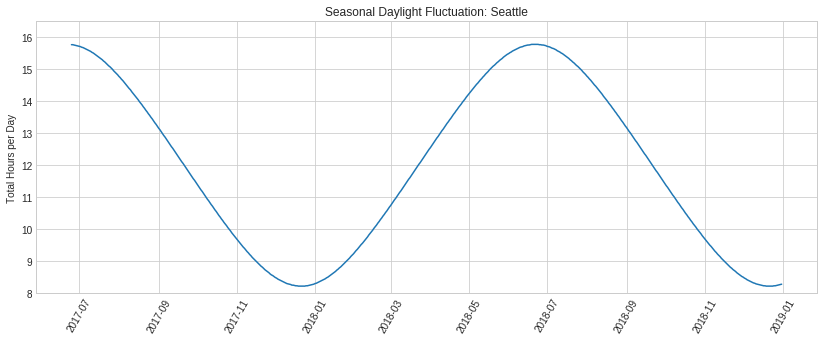

In [13]:
# Visualize daylight fluctuation through the year; all years
# are the same, so looking at a smaller time chunk
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(daily[['daylight_hrs']][-555:])
ax.set(ylim=(8,16.5),
       title='Seasonal Daylight Fluctuation: Seattle',
       ylabel='Total Hours per Day')
plt.xticks(rotation=60)
plt.show()

### Bring months in as features

In [14]:
# one-hot encode each month
months = set(daily.index.month_name())
for month in months:
    daily[month] = make_feature(month == daily.index.month_name())

In [15]:
# This is a TimedeltaIndex, which is subsequently used to calculate an
# absolute percent of time passed since the first measurement
daily['annual'] = (daily.index - daily.index[0]).days / 365.0

### Despite the size of this dataset, it's still good to be aware of memory usage.  Many of the defaults are int64's, simply to encode a 0 or 1.  By casting those to uint8's, we're reducing the memory footprint by a factor of 8 (for that column).  Datasets with millions of rows has made me a bit conservative.

In [16]:
# Drop any rows with null values; do conversions to smaller data types
# to reduce memory bloat.  No need to store a '1' in a 64-bit integer.
daily.dropna(axis=0, how='any', inplace=True)
daily = daily.astype({'holiday': np.uint8,
                      'dry_day': np.uint8,
                      'snow': np.uint8,
                      'daylight_hrs': np.float32,
                      'PRCP': np.float32,
                      'min_temp_F': np.int8,
                      'max_temp_F': np.int8,
                      'avg_temp_F': np.int8})

In [17]:
daily.head()

,Total,min_temp_F,max_temp_F,avg_temp_F,PRCP,dry_day,snow,hvy_prcp,cold_rain,warm,warm_sunny,hot,cold,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,dry_follow_wet,April,June,May,August,September,December,February,October,July,January,March,November,annual
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-10-03,3521,46,66,56,0.0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,11.28,0,0,0,0,0,0,0,0,1,0,0,0,0,0.000000
2012-10-04,3475,47,66,56,0.0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,11.22,0,0,0,0,0,0,0,0,1,0,0,0,0,0.002740
2012-10-05,3148,48,71,59,0.0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,11.16,0,0,0,0,0,0,0,0,1,0,0,0,0,0.005479
2012-10-06,2006,46,75,60,0.0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,11.10,0,0,0,0,0,0,0,0,1,0,0,0,0,0.008219
2012-10-07,2142,46,75,60,0.0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,11.05,0,0,0,0,0,0,0,0,1,0,0,0,0,0.010959


# _Modeling_

In [18]:
X = daily.drop(columns='Total')
y = daily['Total']

## Linear Regression
As it turns out (and with plenty of features), linear regression does well: nearly 90% accuracy in cross-validation.  There might be some tweaking that would increase by another percent, but this is quite good as a baseline.

In [19]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = (model.predict(X)).astype(np.int16)

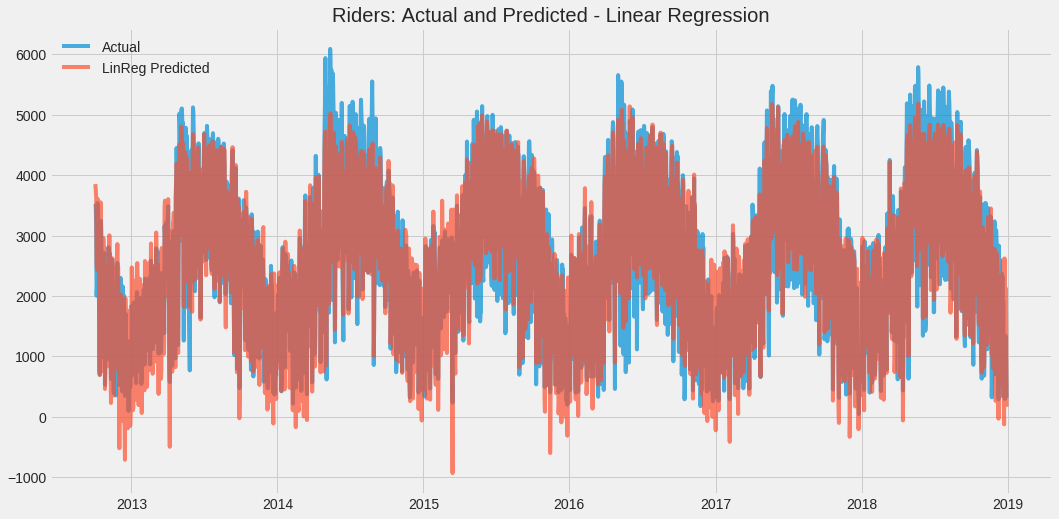

In [20]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(daily[['Total', 'predicted']], alpha=0.7)
ax.set(title='Riders: Actual and Predicted - Linear Regression')
ax.legend({'Actual':'Total', 'LinReg Predicted':'predicted'})
plt.show()

### Make a new model that hasn't seen all the data and cross-validate

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
model2 = LinearRegression(fit_intercept=False)
model2.fit(X_train, y_train)
predictions = model2.predict(X_test)

In [22]:
print(model2.score(X_test, y_test))
cross = cross_val_score(model2, X_train, y_train, cv=5)
print(cross)
print("\nAccuracy: %.2f%% (%.2f%%) standard deviation" % (cross.mean()*100, cross.std()*100))

0.8970193810581879
[0.89148388 0.88900391 0.88843107 0.89931288 0.88441565]

Accuracy: 89.05% (0.49%) standard deviation


## XGBoost - more performant
With a little tuning, XGBoost does very well, over 93% accuracy, cross-validated.  Obviously there is some variance that's not captured in these features.  I can think of things like SeaFair days or other local events that aren't accounted for.

In [24]:
xgb_model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=220, colsample_bylevel=0.4)
xgb_model.fit(X, y)
daily['xgb_predicted'] = (xgb_model.predict(X)).astype(np.int16)

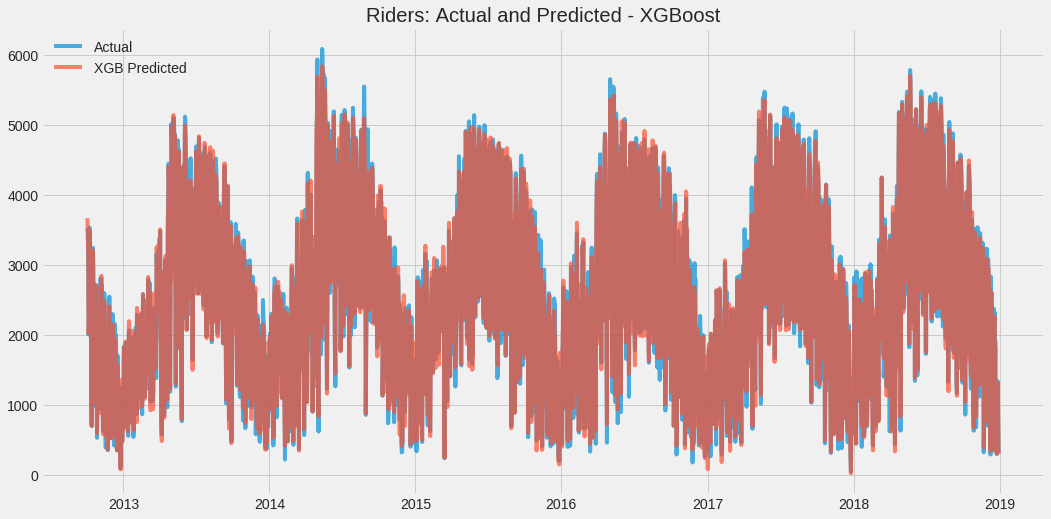

In [25]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(daily[['Total', 'xgb_predicted']], alpha=0.7)
ax.set(title='Riders: Actual and Predicted - XGBoost')
ax.legend({'Actual':'Total', 'XGB Predicted':'xgb_predicted'})
plt.show()

### Cross-validate with a new model that hasn't seen all the data
I could likely get another percent with further refinement of the parameters

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
xgb_model2 = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=220, colsample_bylevel=0.4)
xgb_model2.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

In [27]:
print(xgb_model2.score(X_test, y_test))
cross = cross_val_score(xgb_model2, X_train, y_train, cv=5)
print(cross)
print("\nAccuracy: %.2f%% (%.2f%%) standard deviation" % (cross.mean()*100, cross.std()*100))

0.9356964667821591
[0.93279702 0.92564188 0.92551854 0.94070903 0.92633136]

Accuracy: 93.02% (0.59%) standard deviation


## Feature Importance (XGBoost)
It's interesting that snow has relatively little impact; probably temperature already captures the change.

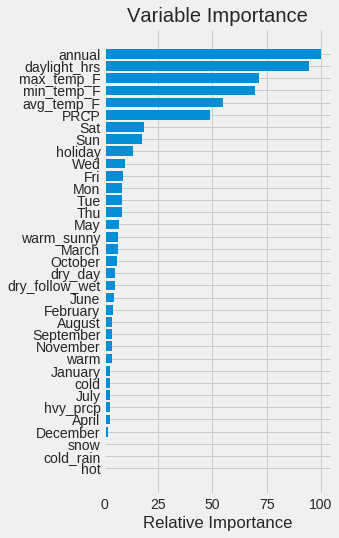

In [28]:
feature_importance = xgb_model2.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Zoom into the curves; XGBoost tracks well, and the overall shape is what was previously seen with weekday/weekend numbers.

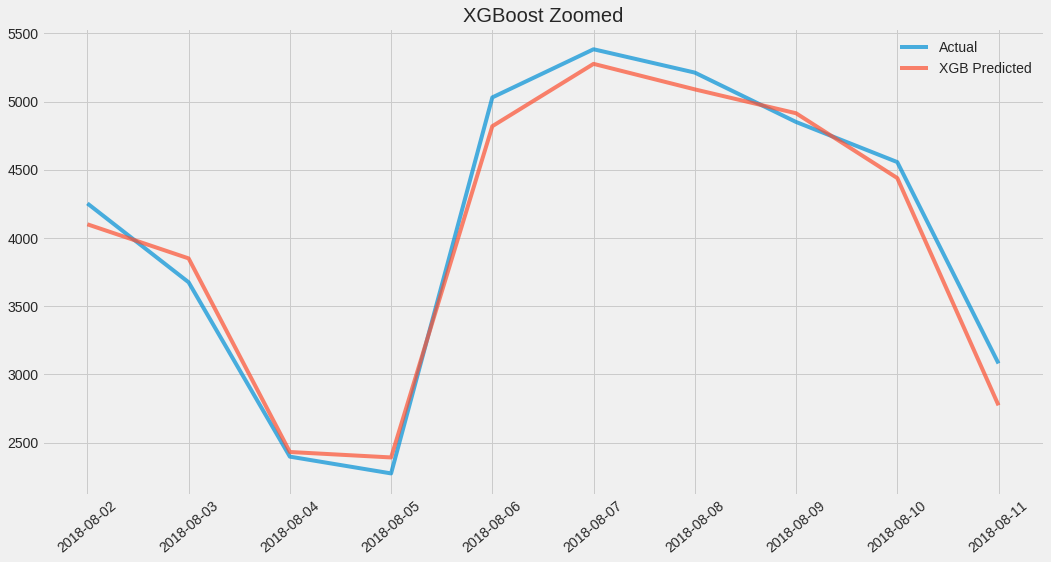

In [29]:
smaller = daily[-150:-140]
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(smaller[['Total', 'xgb_predicted']], alpha=0.7)
ax.set(title='XGBoost Zoomed')
plt.xticks(rotation=40)
ax.legend({'Actual':'Total', 'XGB Predicted':'xgb_predicted'})
plt.show()

In [30]:
from sklearn.utils import resample
params = pd.Series(model.coef_, index=X.columns)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

In [31]:
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(pd.DataFrame({'effect': params.round(0), 'error': err.round(0)}))

                effect  error
min_temp_F          32     18
max_temp_F         104     18
avg_temp_F        -106     36
PRCP              -721     85
dry_day            243     32
snow              -127    158
hvy_prcp            37     63
cold_rain           -2    181
warm                -4     40
warm_sunny         221     43
hot               -408     55
cold               -88     44
Mon                311    170
Tue                422    173
Wed                407    171
Thu                261    172
Fri                -60    171
Sat              -1414    170
Sun              -1509    171
holiday          -1270     93
daylight_hrs        54     22
dry_follow_wet     -46     40
April             -162    128
June               -16    175
May                282    159
August            -206    147
September         -174    109
December          -404     54
February          -225     66
October            -22     76
July              -105    169
January           -163     50
March     

## For fun, compare XGBoost and Linear Regression as an overlay

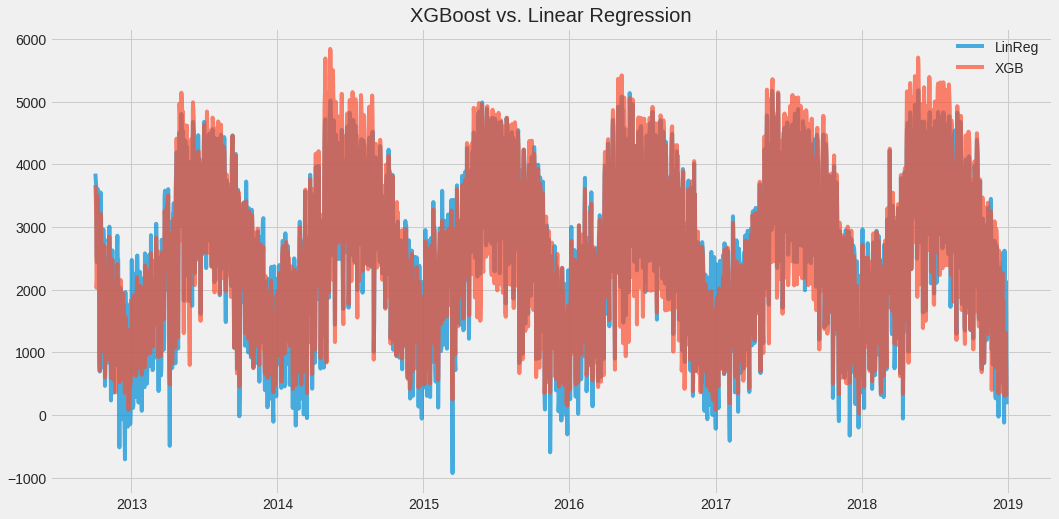

In [32]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(daily[['predicted', 'xgb_predicted']], alpha=0.7)
ax.set(title='XGBoost vs. Linear Regression')
ax.legend({'LinReg':'predicted', 'XGB':'xgb_predicted'})
plt.show()